<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [3]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 489 (delta 70), reused 27 (delta 25), pack-reused 385 (from 1)
Receiving objects: 100% (489/489), 61.04 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (255/255), done.
/content/DATCapstone/data


In [4]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [5]:


df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
149,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,NaN,NaN,NaN,NaN,NaN,1.128571,1.756653,10.863785,9.008606,AAPL
152,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,-3.444626,0.245331,7.016815,0.616699,AAPL
155,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.933334,3.601639,9.637100,-0.162491,AAPL
158,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,0.873398,0.392532,8.744034,2.098389,AAPL
161,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.265976,-1.069687,9.313263,4.827057,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,2025-01-27,394.799988,406.690002,389.000000,397.149994,58125500,0.0,0.0,29723.864,4.0,...,1.174326,-0.262426,0.298183,0.182200,0.388200,0.940002,NaN,NaN,NaN,TSLA
8072,2025-01-28,396.910004,400.589996,386.500000,398.089996,48910700,0.0,0.0,29723.864,4.0,...,0.084330,-0.354550,-0.611864,-0.449780,0.584349,-8.989990,NaN,NaN,NaN,TSLA
8082,2025-01-29,395.209991,398.589996,384.480011,389.100006,68033600,0.0,0.0,29723.864,4.0,...,0.827862,-0.620100,-0.024186,-0.439615,0.781107,11.179993,NaN,NaN,NaN,TSLA
8092,2025-01-30,410.779999,412.500000,384.410004,400.279999,98092900,0.0,0.0,29723.864,4.0,...,1.383147,-0.616897,-0.145329,-0.418483,0.636253,4.320007,NaN,NaN,NaN,TSLA


In [6]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
# Correct path for ZIP file
zip_path = '/content/DATCapstone/data/_data.csv.zip'

# Extract specific file from ZIP
with ZipFile(zip_path, 'r') as z:
    with z.open('data.csv') as f:  # Explicitly specify the file to extract
        df = pd.read_csv(f, index_col=0)


df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [7]:
import glob

# Read articles df
csv_files = glob.glob(os.path.join("data", "*articles*.csv"))

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

ValueError: No objects to concatenate

In [8]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# PCA columns
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)
df_non_pca = df.drop(columns=emb_cols)

df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82,emb_pca_83
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
random_forest(df, 'Target_1day')
random_forest(df, 'Target_1week')
random_forest(df, 'Target_1month')
random_forest(df, 'Target_1year')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()

    # Target setting
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    df['Date'] = pd.to_datetime(df['Date'])

    # Ticker encoding
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
lightgbm_model(df, 'Target_1day')
lightgbm_model(df, 'Target_1week')
lightgbm_model(df, 'Target_1month')
lightgbm_model(df, 'Target_1year')

In [ ]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')

In [12]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [13]:
target_column = 'Close'

# Drop non-numeric or irrelevant columns (like date, ticker, sentiment, embeddings, etc.)
drop_cols = ['Date', 'Ticker']  # Add more if needed
feature_cols = [col for col in df.columns if col not in drop_cols + [target_column]]

features = df[feature_cols].fillna(0)
target = df[[target_column]].fillna(0)

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

In [14]:
SEQ_LEN = 30  # Sequence length: 30 days
X_seq, y_seq = [], []

for i in range(SEQ_LEN, len(features_scaled)):
    X_seq.append(features_scaled[i-SEQ_LEN:i])
    y_seq.append(target_scaled[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

In [16]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use the last output
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
model = StockLSTM(input_size)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.0191
Epoch [10/20], Loss: 0.0175
Epoch [15/20], Loss: 0.0162
Epoch [20/20], Loss: 0.0138


In [18]:
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()
    preds_rescaled = target_scaler.inverse_transform(preds)
    y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

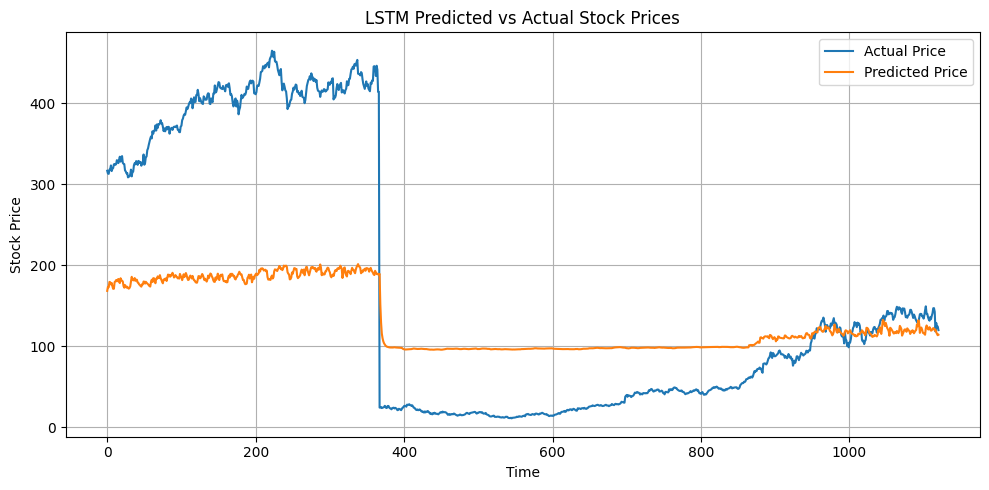

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(preds_rescaled, label='Predicted Price')
plt.title('LSTM Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, preds_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, preds_rescaled)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


RMSE: 131.80
MAE: 104.06


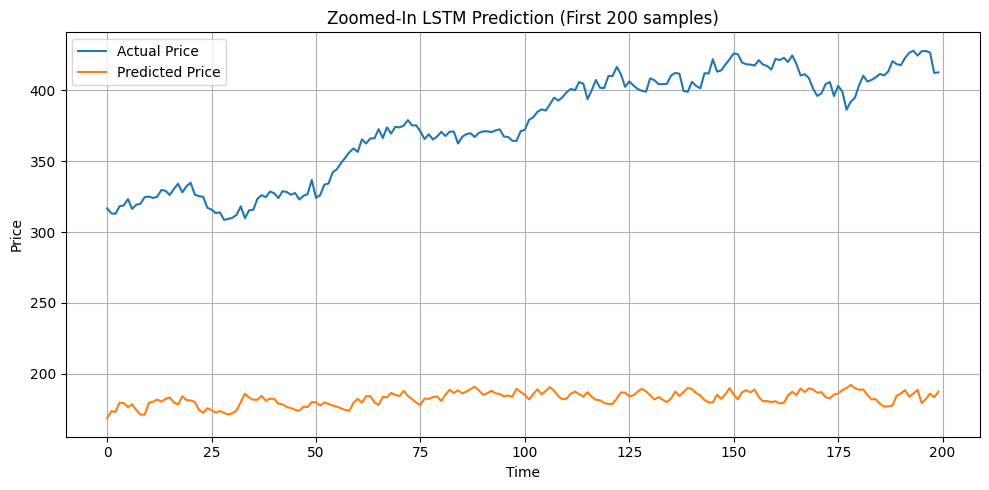

In [22]:
plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled[:200], label='Actual Price')
plt.plot(preds_rescaled[:200], label='Predicted Price')
plt.title('Zoomed-In LSTM Prediction (First 200 samples)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


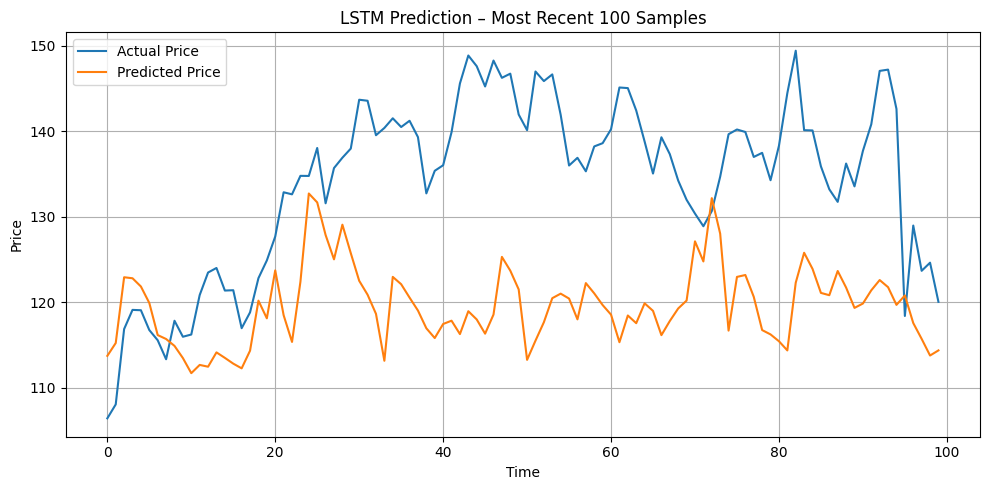

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[-100:], label='Actual Price')
plt.plot(preds_rescaled[-100:], label='Predicted Price')
plt.title('LSTM Prediction – Most Recent 100 Samples')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])

# Fill missing values (Forward fill for most features and 0 for sentiment values)
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)
df = df.dropna(subset=df.columns[0:-5])

# Normalize the 'Close' price (the target)
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])

# Define the window for LSTM (number of previous time steps to consider for prediction)
window_size = 60  # Lookback window of 60 days for prediction

# Prepare the data for LSTM (using a sliding window to create sequences)
def create_lstm_data(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])  # previous 'window_size' values
        y.append(data[i, 0])  # Target variable (next day close price)
    return np.array(X), np.array(y)

# Preparing data
data = df[['Close']].values  # We are using only the 'Close' price as the feature
X, y = create_lstm_data(data, window_size)

# Reshape X to be 3D for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0185 - val_loss: 0.0042
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 4.8100e-04 - val_loss: 0.0032
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 5.2750e-04 - val_loss: 0.0025
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 4.3848e-04 - val_loss: 0.0022
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 3.1447e-04 - val_loss: 0.0019
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 4.1869e-04 - val_loss: 0.0016
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 3.6948e-04 - val_loss: 0.0015
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 3.0647e-04 - val_loss: 0.0014
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 2.9650e-04 - val_loss: 0.0015
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 2.9855e-04 - val_loss: 0.0011
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 2.3168e-04 - val_loss: 0.

In [30]:
preds = model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [31]:
preds_rescaled = scaler.inverse_transform(preds)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

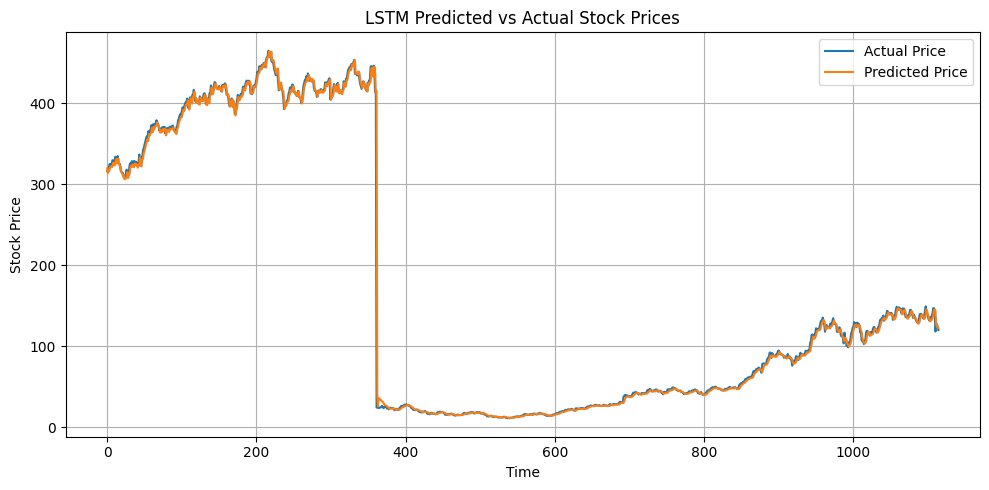

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(preds_rescaled, label='Predicted Price')
plt.title('LSTM Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
mse = mean_squared_error(y_test_rescaled, preds_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, preds_rescaled)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 12.43
MAE: 3.17
